In [1]:
#Loading necessary libraraies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import normalize
from skimage.io import imread
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision.datasets.folder import default_loader
from torch.utils import data
import torch.optim as optim
import cv2
import random

In [2]:
# loading dataset
train = pd.read_csv('Train.csv')
train.head()
test = pd.read_csv('Test.csv')
test.head()
meta_data = pd.read_csv('Meta.csv')
meta_data.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [3]:
#loading train images to numpy array
random.seed(123 )
train_x=[]
for i in train['Path']:
    try:
        img = Image.fromarray(cv2.imread(i), 'RGB') #reading image
        train_x.append(np.array(img.resize((32, 32)))) #converting to numpy and append to list
    except AttributeError:
        print("Error in loading image")


train_x=np.array(train_x)
train_y = np.array(train['ClassId'].values) #storing class labels in list
train_x.astype(float)
train_x.shape

(39209, 32, 32, 3)

In [4]:
#loading test images to numpy array
random.seed(123)
test_x=[]
for i in test['Path']:
    try:
        img = Image.fromarray(cv2.imread(i), 'RGB') #reading image
        test_x.append(np.array(img.resize((32, 32)))) #converting to numpy and append to list
    except AttributeError:
        print("Error in loading image")



test_x=np.array(test_x)
test_y = np.array(test['ClassId'].values)  #storing class labels in list
test_x.astype(float)
test_x.shape

(12630, 32, 32, 3)

In [6]:
#normalizing data
train_x_min = train_x.min(axis=(0, 1), keepdims=True)
train_x_max = train_x.max(axis=(0, 1), keepdims=True)
train_x=(train_x - train_x_min)/(train_x_max - train_x_min)

test_x_min = test_x.min(axis=(0, 1), keepdims=True)
test_x_max = test_x.max(axis=(0, 1), keepdims=True)
test_x=(test_x - test_x_min)/(test_x_max - test_x_min)


In [7]:
# transform to torch tensor

tensor_x = torch.Tensor(train_x)
# converting from tensor batch-height-width-channel dimenssion to 
# pytorch tensor expected dimension batch-channel-height-width
tensor_x=tensor_x.permute(0, 3, 1, 2)
tensor_y = torch.Tensor(train_y)
tensor_x_test = torch.Tensor(test_x) 
tensor_x_test=tensor_x_test.permute(0, 3, 1, 2)
tensor_y_test = torch.Tensor(test_y)

my_dataset_x = data.TensorDataset(tensor_x) # create your datset
my_dataset_y = data.TensorDataset(tensor_y) # create your datset
my_dataset_x_test = data.TensorDataset(tensor_x_test) # create your datset
my_dataset_y_test = data.TensorDataset(tensor_y_test) # create your datset

In [8]:
tensor_x.size()

torch.Size([39209, 3, 32, 32])

In [9]:
#loading dataset
trainloader_x = torch.utils.data.DataLoader(my_dataset_x)
trainloader_y = torch.utils.data.DataLoader(my_dataset_y)
testloader_x = torch.utils.data.DataLoader(my_dataset_x_test)
testloader_y = torch.utils.data.DataLoader(my_dataset_y_test)


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.dropout1 = nn.Dropout(p=0.2)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(1 * 48 * 48, 256)
        self.fc2 = nn.Linear(256, 43)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1,1 * 48 * 48)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = UNet()


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

Epoch [1/5],Train Accuracy: 95.94% , Test Accuracy:  0.71%
Epoch [2/5],Train Accuracy: 96.36% , Test Accuracy:  0.71%
Epoch [3/5],Train Accuracy: 96.78% , Test Accuracy:  0.71%
Epoch [4/5],Train Accuracy: 97.11% , Test Accuracy:  0.71%
Epoch [5/5],Train Accuracy: 97.34% , Test Accuracy:  0.71%


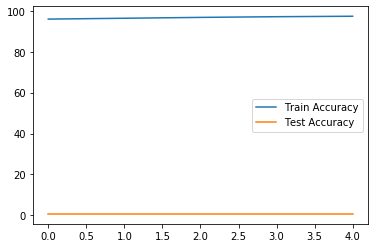

In [12]:
random.seed(100)
num_epochs=5
train_accuracy=[]
test_accuracy=[]
epochs=[]
total_train = 0
correct_train = 0
correct_test = 0
total_test = 0
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()
    for i, (data, data2) in enumerate(zip(trainloader_x,trainloader_y), 0):
        
        # get the inputs and labels
        inputs= data[0][0]
        labels=data2[0].type(torch.LongTensor)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs[None,...])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #Calculate train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.nelement()
        correct_train += predicted.eq(labels.data).sum().item()
        train_acc = 100 * correct_train / total_train
        
        running_loss += loss.item()
    
    
    with torch.no_grad():
        net.eval()
        for i,(data_test, data2_test) in enumerate(zip(testloader_x,testloader_y),0):
            test_inputs= data_test[0][0]
            test_labels=data2_test[0].type(torch.LongTensor)
            outputs_test = net(test_inputs[None,...])
            
             #Calculate test accuracy
            _, predicted_test = torch.max(outputs_test.data, 1)
            total_test += test_labels.nelement()
            correct_test += predicted_test.eq(test_labels.data).sum().item()
            test_acc = 100 * correct_test / total_test
        
    train_accuracy.append(train_acc)    
    epochs.append(epoch)         
    test_accuracy.append(test_acc)    
    print('Epoch [{}/{}],Train Accuracy: {:.2f}% , Test Accuracy:  {:.2f}%'
        .format(epoch + 1, num_epochs,
                train_acc,test_acc))
    
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend()

In [ ]:
# Test overall accuracy of the model
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for i,(data, data2) in enumerate(zip(testloader_x,testloader_y),0):
        inputs= data[0][0]
        labels=data2[0].type(torch.LongTensor)
        
        outputs = net(inputs[None,...])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.nelement()
        correct += predicted.eq(labels.data).sum().item()

    print('Test Accuracy of the model on  test images: {} %'.format((correct / total) * 100))
    print(correct)
    print(total)
    